In [8]:
%matplotlib widget

import sys  
sys.path.insert(0, '/home/cbisot/pycode/MscThesis/')
import pandas as pd
from sample.util import get_dates_datetime, get_dirname, get_plate_number, get_postion_number

import ast
from sample.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
from sample.pipeline.functions.node_id import orient
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from sample.pipeline.functions.extract_graph import from_sparse_to_graph, generate_nx_graph, sparse_to_doc
from skimage.feature import hessian_matrix_det
from sample.pipeline.functions.experiment_class_surf import Experiment, Edge, Node
from sample.paths.directory import run_parallel, find_state, directory_scratch, directory_project

In [3]:
directory = "/projects/0/einf914/data/"

In [4]:
plate = 40
begin = 0
end = 37
dates_datetime = get_dates_datetime(directory,plate)
dates_datetime.sort()
dates_datetime_chosen = dates_datetime[begin : end + 1]
dates = dates_datetime_chosen
exp = Experiment(plate, directory)
exp.load(dates,True)

In [9]:
edges = set()
for t in range(exp.ts):
    graph = exp.nx_graph[t]
    for edge in graph.edges:
        edge_obj = Edge(Node(min(edge),exp),Node(max(edge),exp),exp)
        edges.add(edge_obj)

In [28]:
edge = choice(list(edges))
print(edge.ts(),len(edge.pixel_list(edge.ts()[0])))

[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37] 110


In [29]:
plt.rcParams.update({'font.size': 22})
fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
ax.plot(edge.ts(),[edge.width(t) for t in edge.ts()])
ax.set_xlabel('timestep')
ax.set_ylabel(r'width ($\mu m $)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'width ($\\mu m $)')

In [5]:
t0=33
pixels=[]
for edge in edges:
    if edge.is_in(t0):
        pixels.append(((edge.begin.pos(t0)+edge.end.pos(t0))/2,edge.width(t0)))



In [56]:
help(plt.cm.get_cmap('plasma'))

Help on ListedColormap in module matplotlib.colors object:

class ListedColormap(Colormap)
 |  ListedColormap(colors, name='from_list', N=None)
 |  
 |  Colormap object generated from a list of colors.
 |  
 |  This may be most useful when indexing directly into a colormap,
 |  but it can also be used to generate special colormaps for ordinary
 |  mapping.
 |  
 |  Method resolution order:
 |      ListedColormap
 |      Colormap
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, colors, name='from_list', N=None)
 |      Make a colormap from a list of colors.
 |      
 |      *colors*
 |          a list of matplotlib color specifications,
 |          or an equivalent Nx3 or Nx4 floating point array
 |          (*N* rgb or rgba values)
 |      *name*
 |          a string to identify the colormap
 |      *N*
 |          the number of entries in the map.  The default is *None*,
 |          in which case there is one colormap entry for each
 |          element in

In [62]:
t0=10
plt.close('all')
# fig = plt.figure()
# ax = fig.add_subplot(111)
exp.plot_raw(t0)
for edge in edges:
    if edge.is_in(t0):
        try:
            width = edge.width(t0)
        except:
            print(edge)
        begin = edge.begin.pos(t0)
        end = edge.end.pos(t0)
        plt.plot((begin[1]//5,end[1]//5), (begin[0]//5,end[0]//5),color = plt.cm.get_cmap('plasma')(width/60))
sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('plasma'), norm=plt.Normalize(vmin=0, vmax=60))
sm._A = []
plt.colorbar(sm)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(Node(775), Node(1088))
(Node(1160), Node(1466))


In [34]:
x,y,c = [pixel[0][0]for pixel in pixels],[pixel[0][1] for pixel in pixels], [pixel[1] for pixel in pixels]

In [35]:
X, Y = np.meshgrid(x, y)

ValueError: not enough values to unpack (expected 2, got 1)

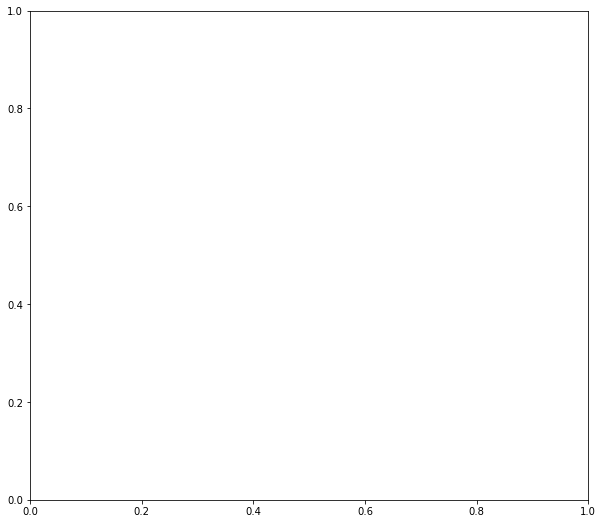

In [37]:
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.pcolormesh(X,Y,c)

In [38]:
np.random.rand(6, 10)

array([[0.65184612, 0.66056643, 0.12499956, 0.7364519 , 0.1793078 ,
        0.42830398, 0.86415191, 0.46723791, 0.28685484, 0.60543425],
       [0.49024466, 0.03816605, 0.63126177, 0.15640546, 0.02297815,
        0.33344225, 0.58576963, 0.0881237 , 0.1128793 , 0.69476874],
       [0.42492862, 0.43227348, 0.42959667, 0.49371282, 0.17220331,
        0.04714904, 0.17751601, 0.3878863 , 0.24217817, 0.54123831],
       [0.33657338, 0.69719528, 0.38260422, 0.00809375, 0.49907962,
        0.62683143, 0.42223888, 0.61668441, 0.16818435, 0.96519325],
       [0.14741769, 0.33200052, 0.45050359, 0.47443733, 0.86062992,
        0.11826813, 0.78142622, 0.61928262, 0.69741385, 0.94069517],
       [0.14954074, 0.29846353, 0.80996295, 0.5451993 , 0.14765597,
        0.81791178, 0.35439332, 0.22418863, 0.1677418 , 0.09178806]])

In [2]:
class Edge:
    def __init__(self, begin, end, experiment):
        self.begin = begin
        self.end = end
        self.experiment = experiment

    def __eq__(self, other):
        return (self.begin == other.begin and self.end == other.end)

    def __repr__(self):
        return f"Edge({self.begin},{self.end})"

    def __str__(self):
        return str((self.begin, self.end))
    
    def __hash__(self):
        return (self.begin, self.end).__hash__()

    def is_in(self, t):
        return (self.begin.label, self.end.label) in self.experiment.nx_graph[t].edges
    
    def ts(self):
        return [t for t in range(self.experiment.ts) if self.is_in(t)]

    def pixel_list(self, t):
        return orient(
            self.experiment.nx_graph[t].get_edge_data(self.begin.label, self.end.label)[
                "pixel_list"
            ],
            self.begin.pos(t),
        )
    def width(self, t):
        return (self.experiment.nx_graph[t].get_edge_data(self.begin.label, self.end.label)[
                "width"
            ])


    def orientation_whole(self, t):
        pixel_list = np.array(self.pixel_list(t))
        vector = pixel_list[-1] - pixel_list[0]
        unit_vector = vector / np.linalg.norm(vector)
        vertical_vector = np.array([-1, 0])
        dot_product = np.dot(vertical_vector, unit_vector)
        if (
            vertical_vector[1] * vector[0] - vertical_vector[0] * vector[1] >= 0
        ):  # determinant
            angle = np.arccos(dot_product) / (2 * np.pi) * 360
        else:
            angle = -np.arccos(dot_product) / (2 * np.pi) * 360
        return angle

    def orientation_begin(self, t, length=20):
        pixel_list = np.array(self.pixel_list(t))
        vector = pixel_list[min(length, len(pixel_list) - 1)] - pixel_list[0]
        unit_vector = vector / np.linalg.norm(vector)
        vertical_vector = np.array([-1, 0])
        dot_product = np.dot(vertical_vector, unit_vector)
        if (
            vertical_vector[1] * vector[0] - vertical_vector[0] * vector[1] >= 0
        ):  # determinant
            angle = np.arccos(dot_product) / (2 * np.pi) * 360
        else:
            angle = -np.arccos(dot_product) / (2 * np.pi) * 360
        return angle

    def orientation_end(self, t, length=20):
        pixel_list = np.array(self.pixel_list(t))
        vector = pixel_list[-1] - pixel_list[max(0, len(pixel_list) - 1 - length)]
        unit_vector = vector / np.linalg.norm(vector)
        vertical_vector = np.array([-1, 0])
        dot_product = np.dot(vertical_vector, unit_vector)
        if (
            vertical_vector[1] * vector[0] - vertical_vector[0] * vector[1] >= 0
        ):  # determinant
            angle = np.arccos(dot_product) / (2 * np.pi) * 360
        else:
            angle = -np.arccos(dot_product) / (2 * np.pi) * 360
        return angle
